In [60]:
import pandas as pd
import geopandas as gpd
import cbsodata
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [84]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Zoek op welke data beschikbaar is
metadata = pd.DataFrame(cbsodata.get_meta('83765NED', 'DataProperties'))

In [91]:
#TotaalCBSTabel = pd.DataFrame(cbsodata.get_data('60048NED'))

In [2]:
cbsTabelOrgineel = pd.DataFrame(cbsodata.get_data('60048NED', select = ["Perioden", "RegioS", "k_15Tot20Jaar_93", "k_20Tot25Jaar_94", "k_15Tot20Jaar_162", "k_20Tot25Jaar_163"]))
cbsTabelOrgineel = cbsTabelOrgineel.rename(columns = {"k_15Tot20Jaar_93": "Gevestigd_15_20", 
                                                      "k_20Tot25Jaar_94": "Gevestigd_20_25", 
                                                      "k_15Tot20Jaar_162": "Vertrokken_15_20", 
                                                      "k_20Tot25Jaar_163": "Vertrokken_20_25"})
cbsTabelOrgineel.head()

,Perioden,RegioS,Vertrokken_15_20,Gevestigd_15_20,Vertrokken_20_25,Gevestigd_20_25
0,1988,Nederland,58151.0,58151.0,132599.0,132599.0
1,1989,Nederland,57134.0,57134.0,137107.0,137107.0
2,1990,Nederland,53024.0,53024.0,131743.0,131743.0
3,1991,Nederland,50282.0,50282.0,129663.0,129663.0
4,1992,Nederland,47487.0,47487.0,129569.0,129569.0


In [3]:
dfStudenten = pd.read_csv("VerhuisdePersonen15-25.csv", sep = ";")
dfStudenten = dfStudenten.dropna()
dfStudenten = dfStudenten.rename(columns = {"Regio's": "Regio"})

In [87]:
cbsTabel = cbsTabelOrgineel.loc[cbsTabelOrgineel.RegioS.isin(dfStudenten.Regio), :]
cbsTabel = cbsTabel.loc[cbsTabel.Perioden.astype(int) >= 2010, :]
cbsTabel = cbsTabel.dropna()
cbsTabel.RegioS = cbsTabel.RegioS.str.replace(" \(gemeente\)", "")
    
cbsTabel = cbsTabel.sort_values(by = "Gevestigd_20_25", ascending = False)

In [89]:
geodata_url = "https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json"
gemeentegrenzen = gpd.read_file(geodata_url)
gemeentegrenzen.to_file("GemeenteGrenzen2017.geojson", driver='GeoJSON')

In [71]:
gemeenteData = pd.merge(gemeentegrenzen, cbsTabel.head(40),
                           left_on = "statnaam", 
                           right_on = "RegioS",
                       how = "outer")

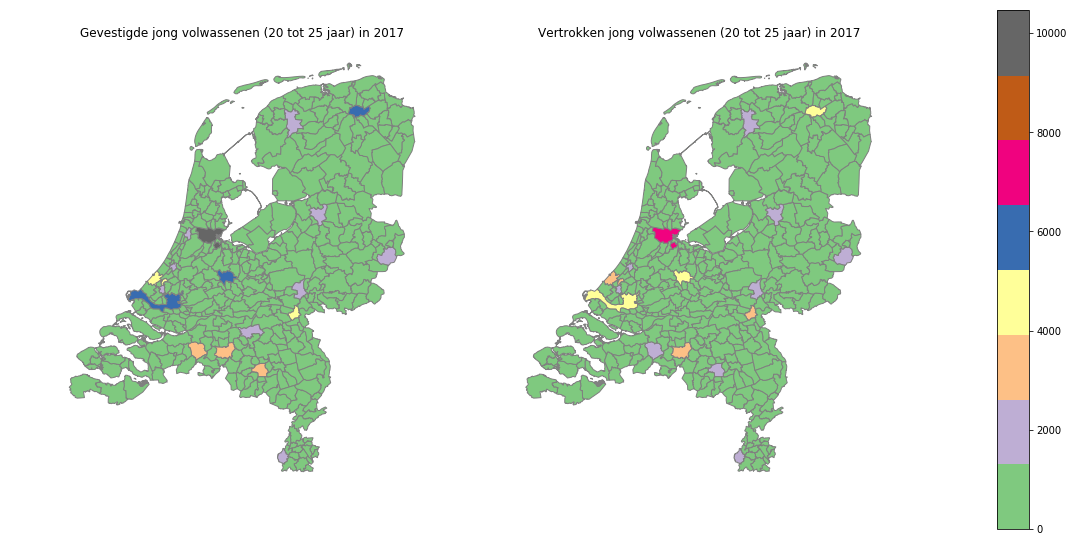

In [86]:
cmap = cm.get_cmap('Accent')

vmin = 0
vmax = max(gemeenteData.Gevestigd_20_25.max(), gemeenteData.Vertrokken_20_25.max())

fig, (ax1, ax2) = mpl.pyplot.subplots(ncols=2, figsize = [15, 12])
# Maak een thematische kaart
p1 = gemeenteData.plot(ax = ax1,
                      column='Gevestigd_20_25', 
                      figsize = (10,8),
                      edgecolor = "grey",
                      cmap = cmap,
                      vmin = vmin,
                      vmax = vmax)
p1.axis('off')
p1.set_title("Gevestigde jong volwassenen (20 tot 25 jaar) in 2017")

p2 = gemeenteData.plot(ax = ax2,
                      column='Vertrokken_20_25', 
                      figsize = (10,8),
                      edgecolor = "grey",
                      cmap = cmap,
                      vmin = vmin,
                      vmax = vmax)
p2.axis('off')
p2.set_title("Vertrokken jong volwassenen (20 tot 25 jaar) in 2017")

cax = fig.add_axes([1, 0.2, 0.03, 0.6])
sm = cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)

fig.show()